# Puget Sound Plotting

In [1]:
import erddapy
from erddapy import ERDDAP
import numpy as np
import pandas as pd
import xarray
import cf_xarray
import datetime
import netCDF4
from netCDF4 import Dataset

import matplotlib
from matplotlib import pyplot as plt

Downloading the Mooring Datasets

In [2]:
def get_erddap_data(erddap_url, dataset, data_protocol="griddap", variables=None, constraints=None):
    """
    Function: get_erddap_data
    This function uses the erddapy python library to access data from ERDDAP servers,
    and to return it to users in convenient formats for python users.
    Data can be pulled from "tabledap" or "griddap" formats, with different
    output types, depending on the dap type.
    
    Inputs:
    erddap_url    - The url address of the erddap server to pull data from
    variables     - The selected variables within the dataset.
    data_protocol - The erddap data protocol for the chosen dataset.
                    Options include "tabledap" or "griddap"
                    The default option is given as "griddap"
    dataset       - The ID for the relevant dataset on the erddap server
                    If no variables are given, it is assumed that all variables
                    will be pulled.
    constraints   - These are set by the user to help restrict the data pull
                    to only the area and timeframe of interest.
                    If no constraints are given, all data in a dataset is pulled.
                    Constraints should be given as a dictionary, where
                    each entry is a bound and/or selection of a specific axis variable
                    Exs. {"longitude<=": "min(longitude)+10", "longitude>=": "0"}
                         {"longitude=": "140", "time>=": "max(time)-30"}
    
    Outputs:
    erddap_data   - This variable contains the pulled data from the erddap server.
                    If the data_protocol is "griddap",  then erddap_data is an xarray dataset
                    If the data_protocol is "tabledap", then erddap_data is a pandas dataframe
    """
    
    import erddapy
    from erddapy import ERDDAP
    import pandas as pd
    import xarray
    
    
    ############################################
    # Set-up the connection to the ERDDAP server
    ############################################
    
    # Connect to the erddap server
    e = ERDDAP(server=erddap_url, protocol=data_protocol, response='csv')
    
    # Identify the dataset of interest
    e.dataset_id = dataset
    
    
    #########################################
    # Pull the data, based upon protocol type
    #########################################
    
    # GRIDDAP Protocol
    if data_protocol == "griddap":
        
        # Initialize the connection
        e.griddap_initialize()

        # Update the constraints
        if constraints is not None:
            e.constraints.update(constraints)
            e.griddap_initialize()
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables

        erddap_data = e.to_xarray()
    
    # TABLEDAP Protocol
    elif data_protocol == "tabledap":

        # Update the constraints
        if constraints is not None:
            e.constraints = constraints
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables
            
        erddap_data = e.to_pandas()
    
    # Invalid protocol given
    else:
        print('Invalid ERDDAP protocol. Given protocol is: ' + data_protocol)
        print('Valid protocols include "griddap" or "tabledap". Please restart and try again with a valid protocol')
        erddap_data = None
    
    
    #############################
    return erddap_data

Extracting Data for Plotting at Specific Depth for Two Mooring Sub-stations

Visualising the Study Area

In [3]:
#
import folium
tiles = (
    "http://services.arcgisonline.com/arcgis/rest/services/"
    "World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}"
)

#set the boundary box
min_lat, max_lat = 47.25,48.0
min_lon, max_lon = -123.2,-122.3
lon = (min_lon + max_lon) / 2
lat = (min_lat + max_lat) / 2
#m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=8)
m = folium.Map(location=[lat, lon], tiles=tiles, attr="ESRI", zoom_start=8)
folium.Marker([47.907,-122.627], popup="Hansville", tooltip="Hansville",icon=folium.Icon(color="red")).add_to(m)
folium.Marker([47.761,-122.3972], popup="Point Wells", tooltip="Point Wells",icon=folium.Icon(color="red")).add_to(m)
folium.Marker([47.8034,-122.8029], popup="Dabob Bay", tooltip="Dabob Bay").add_to(m)
folium.Marker([47.28,-122.728], popup="Carr Inlet", tooltip="Carr Inlet").add_to(m)
folium.Marker([47.375,-123.0083], popup="Twanoh", tooltip="Twanoh").add_to(m)
folium.Marker([47.4218,-123.1136], popup="Hoodsport", tooltip="Hoodsport").add_to(m)
folium.Polygon([(min_lat, min_lon), (max_lat, min_lon), (max_lat, max_lon), (min_lat, max_lon)],fill=True,color= "black",weight="2",
              dashArray= "5, 5",).add_to(m)
m

In [4]:
nwem_url = 'http://nwem.apl.washington.edu/erddap'

nwem_dataset1 = 'orca3_L3_depthgridded_025'
nwem_dataset2 = 'npby1_L3_depthgridded_025'

variables = ["sea_water_temperature",
             "sea_water_practical_salinity","mass_concentration_of_oxygen_in_sea_water","sea_water_temperature_qc_agg",
             "sea_water_practical_salinity_qc_agg","mass_concentration_of_oxygen_in_sea_water_qc_agg"]

constraints = {"cast_start_time>=":datetime.datetime(2012,1,1).strftime('%Y-%m-%dT%H:%M:%SZ')}
#constraints = {"cast_start_time>=": "max(cast_start_time)-365"}

nwem_grid1 = get_erddap_data(nwem_url, nwem_dataset1, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

nwem_grid2 = get_erddap_data(nwem_url, nwem_dataset2, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

In [5]:
ds1=nwem_grid1; ds2=nwem_grid2; 

In [6]:
depth1=np.array(ds1.depth.values[:]); depth2=np.array(ds2.depth.values[:]); 
date1=np.array(ds1.cast_start_time.values[:]); date2=np.array(ds2.cast_start_time.values[:])#325
depth_l="50"

In [7]:
str1="sea_water_temperature"; str2="sea_water_practical_salinity";str3='mass_concentration_of_oxygen_in_sea_water';
str4="sea_water_temperature_qc_agg"; str5="sea_water_practical_salinity_qc_agg";str6='mass_concentration_of_oxygen_in_sea_water_qc_agg';

In [8]:
var1_sst=ds1[str1]; var1_sss=ds1[str2]; var1_oxy=ds1[str3]; var1_sstqc=ds1[str4]; var1_sssqc=ds1[str5]; var1_oxyqc=ds1[str6]; ## Accessing buoy1
var1_sst=var1_sst.where(var1_sstqc == 1); var1_sss=var1_sss.where(var1_sssqc == 1); var1_oxy=var1_oxy.where(var1_oxyqc == 1) ## Extracting only good data 

var2_sst=ds2[str1]; var2_sss=ds2[str2]; var2_oxy=ds2[str3]; var2_sstqc=ds2[str4]; var2_sssqc=ds2[str5]; var2_oxyqc=ds2[str6]## Accessing buoy2
var2_sst=var2_sst.where(var2_sstqc==1); var2_sss=var2_sss.where(var2_sssqc==1); var2_oxy=var2_oxy.where(var2_oxyqc==1); 

In [9]:
var1_sst=var1_sst.assign_coords(time=("cast_start_time",date1))
var1_sss=var1_sss.assign_coords(time=("cast_start_time",date1))
var1_oxy=var1_oxy.assign_coords(time=("cast_start_time",date1))

var2_sst=var2_sst.assign_coords(time=("cast_start_time",date2))
var2_sss=var2_sss.assign_coords(time=("cast_start_time",date2))
var2_oxy=var2_oxy.assign_coords(time=("cast_start_time",date2))

In [10]:
tser1_sst=var1_sst.isel(depth=int(depth_l)); tser2_sst=var2_sst.isel(depth=int(depth_l))
tser1_sss=var1_sss.isel(depth=int(depth_l)); tser2_sss=var2_sss.isel(depth=int(depth_l))
tser1_oxy=var1_oxy.isel(depth=int(depth_l)); tser2_oxy=var2_oxy.isel(depth=int(depth_l))       

Time_Series Comparison of Temp, Salinity, and Oxygen at a depth for the two sub-stations Orca3 and Nbpy1

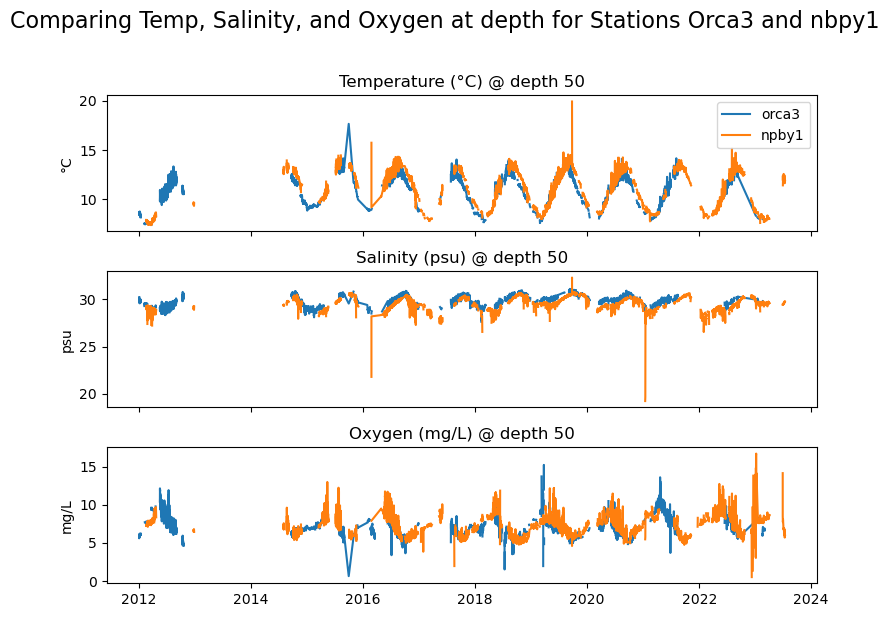

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))  # Share x-axis
t1 = ax1.plot(ds1.cast_start_time, tser1_sst,label='orca3'); t1_1=ax1.plot(ds2.cast_start_time, tser2_sst,label='npby1');
t2 = ax2.plot(ds1.cast_start_time, tser1_sss); t2_2 = ax2.plot(ds2.cast_start_time, tser2_sss)
t3 = ax3.plot(ds1.cast_start_time, tser1_oxy); t3_2 = ax3.plot(ds2.cast_start_time, tser2_oxy)


ax1.set_title("Temperature (°C) @ depth " + depth_l)
ax1.set_xlabel("")
ax1.set_ylabel("°C")
#ax1.set_xticks(ds.cast_start_time[tick_positions].values)
ax1.set_xticklabels([])
ax1.legend()

ax2.set_title("Salinity (psu) @ depth " + depth_l)
ax2.set_xlabel("")
ax2.set_ylabel("psu")
#ax1.set_xticks(ds.cast_start_time[tick_positions].values)
ax2.set_xticklabels([])

ax3.set_title("Oxygen (mg/L) @ depth " + depth_l)
ax3.set_xlabel("")
ax3.set_ylabel("mg/L")

#ax1.set_xticks(ds.cast_start_time[tick_positions].values)
#ax2.set_xticklabels([])
f.suptitle("Comparing Temp, Salinity, and Oxygen at depth for Stations Orca3 and nbpy1", fontsize=16, y=1.02)
plt.tight_layout()
#t.legend()
plt.show()

Data Preparation for Depth Distribution Plots

In [12]:
sst1=var1_sst.transpose(); sst2=var2_sst.transpose();
sss1=var1_sss.transpose(); sss2=var2_sss.transpose();
oxy1=var1_oxy.transpose(); oxy2=var2_oxy.transpose();

In [13]:
#oxy1.max() # , vmin=19,vmax=32.6  ,vmin=0.1,vmax=18

In [14]:
formatted_time = np.datetime_as_string(date1, unit='D')
tick_positions = np.linspace(0, len(date1) - 1, 6, dtype=int)
tick_labels = [formatted_time[i] for i in tick_positions]

Figure for Comparing Vertical Temperature, Salinity, and Oxygen at Orca3 Sub-Station

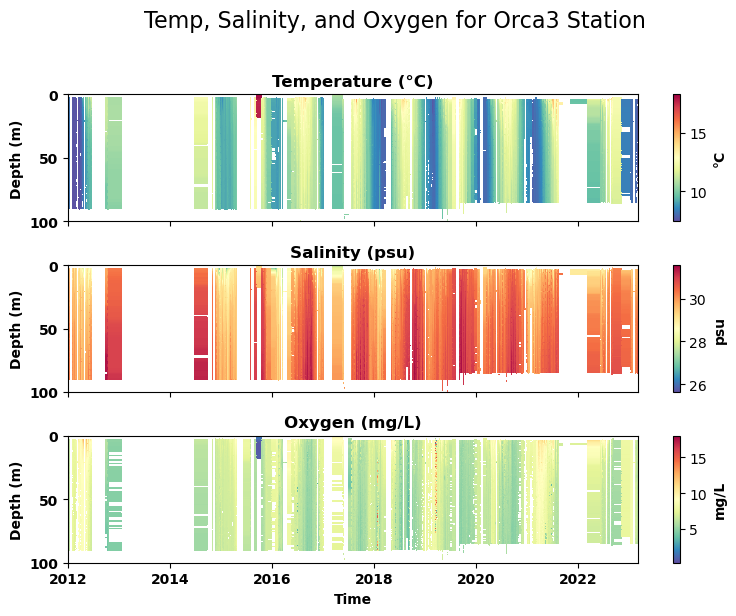

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))  # Share x-axis

# Plot Temperature subplot
sc1 = ax1.pcolor(date1, depth1, sst1, cmap="Spectral_r")
ax1.set_title("Temperature (°C)")
ax1.set_xlabel("")
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()  # Invert y axis
#ax1.set_xticks(date[tick_positions])
ax1.set_xticklabels([])

# Plot Salinity subplot
sc2 = ax2.pcolor(date1, depth1, sss1, cmap="Spectral_r")
ax2.set_title("Salinity (psu)")
ax2.set_xlabel("")
ax2.set_ylabel("Depth (m)")
ax2.invert_yaxis()  # Invert y axis
#ax2.set_xticks(date[tick_positions])
ax2.set_xticklabels([])

# Plot Oxygen subplot
sc3 = ax3.pcolor(date1, depth1, oxy1, cmap="Spectral_r")
ax3.set_title("Oxygen (mg/L)")
ax3.set_ylabel("Depth (m)")
ax3.set_xlabel("Time")
#ax3.xaxis.set_major_locator(plt.FixedLocator(tick_positions))
#ax3.set_xticks(date[tick_positions])  # Set tick positions for the third row
#ax3.set_xticklabels(tick_labels, ha='center')  # Set tick labels for the third row
ax3.invert_yaxis()  # Invert y axis

# Add colorbars
cbar1 = f.colorbar(sc1, ax=ax1, orientation='vertical')
cbar1.ax.set_ylabel('°C',fontweight='bold')
cbar1.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight

cbar2 = f.colorbar(sc2, ax=ax2, orientation='vertical')
cbar2.ax.set_ylabel('psu',fontweight='bold')
cbar2.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight


cbar3 = f.colorbar(sc3, ax=ax3, orientation='vertical')
cbar3.ax.set_ylabel('mg/L',fontweight='bold')
cbar3.ax.yaxis.label.set_fontweight('bold')  # Set colorbar label font weight


for ax in [ax1, ax2, ax3]:
    ax.set_title(ax.get_title(), fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontweight='bold')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
# Adjust layout
f.suptitle("Temp, Salinity, and Oxygen for Orca3 Station", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

End of  Plotting